# Zadanie: Przewidywanie wieku oposów na podstawie cech morfometrycznych

**Cel:**  
W tym zadaniu mamy zbiór danych dotyczących gatunku oposów, zapisany w pliku `possum.csv`. Chcemy zbudować model regresyjny, który na podstawie wymiarów ciała i innych cech będzie przewidywał wiek osobników.

**Dane:**  
Zbiór danych zawiera następujące kolumny:

- **case**: Unikalny identyfikator obserwacji.
- **site**: Numer stanowiska (miejsce odłowu).
- **Pop**: Populacja (np. "Vic" lub inna).
- **sex**: Płeć zwierzęcia ("m" dla samca, "f" dla samicy).
- **age**: Wiek w latach (zmienna docelowa, zawiera 2 brakujące wartości).
- **hdlngth**: Długość głowy (mm).
- **skullw**: Szerokość czaszki (mm).
- **totlngth**: Całkowita długość (mm).
- **taill**: Długość ogona (mm).
- **footlgth**: Długość stopy (mm, 1 brakująca wartość).
- **earconch**: Długość małżowiny usznej (mm).
- **eye**: Wielkość oka (mm).
- **chest**: Obwód klatki piersiowej (cm).
- **belly**: Obwód brzucha (cm).

**Problem:**  
Zmienna docelowa to **age**. Niestety, w zbiorze danych znajdują się brakujące wartości (2 w kolumnie `age` oraz 1 w `footlgth`). Musimy je odpowiednio uzupełnić przed budową modelu.

**Co należy zrobić:**

1. **Wczytać dane** z pliku `possum.csv`.
2. **Zbadać dane**: sprawdzić typy zmiennych, rozkłady, brakujące wartości.
3. **Przetworzyć dane**:  
   - Poradzić sobie z brakującymi wartościami w kolumnach `age` i `footlgth`.  
   - Zakodować zmienne kategoryczne (`Pop`, `sex`) w postaci numerycznej (np. One-Hot Encoding).
   - Zastanowić się, czy potrzebne jest skalowanie cech numerycznych.
4. **Podzielić dane** na zbiór treningowy i testowy.
5. **Zbudować model regresyjny** (np. regresja liniowa, Ridge, Lasso lub inny regresor) i dopasować go do danych treningowych.
6. **Oszacować jakość modelu** na zbiorze testowym za pomocą odpowiednich miar błędu (np. MSE, MAE, R²).

**Wskazówki:**

- Możesz użyć `SimpleImputer` ze scikit-learn do uzupełniania braków (np. średnią dla cech numerycznych).
- Dla cech kategorycznych możesz użyć `OneHotEncoder`.
- Zastanów się nad pipeline’em (`Pipeline`) i `ColumnTransformerem`, aby uporządkować proces przetwarzania danych i modelowania w jednym kroku.
- Wypróbuj różne modele i porównaj ich wyniki.

**Oczekiwany rezultat:**  
Na końcu otrzymasz model, który na podstawie wymiarów ciała i informacji o populacji oraz płci possuma będzie potrafił przewidzieć wiek z pewną dokładnością. Zwróć uwagę na interpretację wyników i oceń, czy model nadaje się do praktycznego zastosowania.



In [164]:
# Wczytaj potrzebne biblioteki
# np. pandas, numpy, matplotlib, seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [165]:

# 1. Wczytaj dane z pliku possum.csv
df = pd.read_csv('possum.csv')


In [166]:

# 2. Wyświetl podstawowe informacje o danych (rozmiar, nagłówki, info o kolumnach)
print('Rozmiar zbioru:',df.shape)
print('Pierwsze wiersze:')
display(df.head())
print('Informacje o zbiorze:')
df.info()

Rozmiar zbioru: (104, 14)
Pierwsze wiersze:


,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


Informacje o zbiorze:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


In [167]:
print("\nStatystyki opisowe dla zmiennych numerycznych:")
(df.describe())


Statystyki opisowe dla zmiennych numerycznych:


,case,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,104.000000,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,52.500000,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,30.166206,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,26.750000,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,52.500000,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,78.250000,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,104.000000,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


In [168]:

# 3. Sprawdź brakujące wartości
print(df.isnull().sum())


case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64


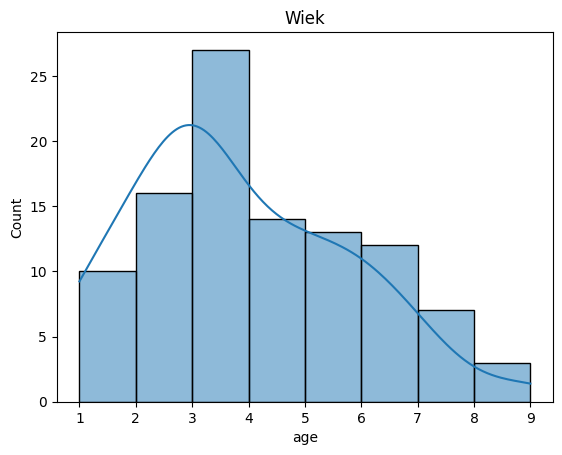

In [169]:
# -------------------------------------
# Wizualizacje
# -------------------------------------
# Rozkład zmiennej docelowej (age)
sns.histplot(df['age'], kde=True)
plt.title("Wiek")
plt.show()

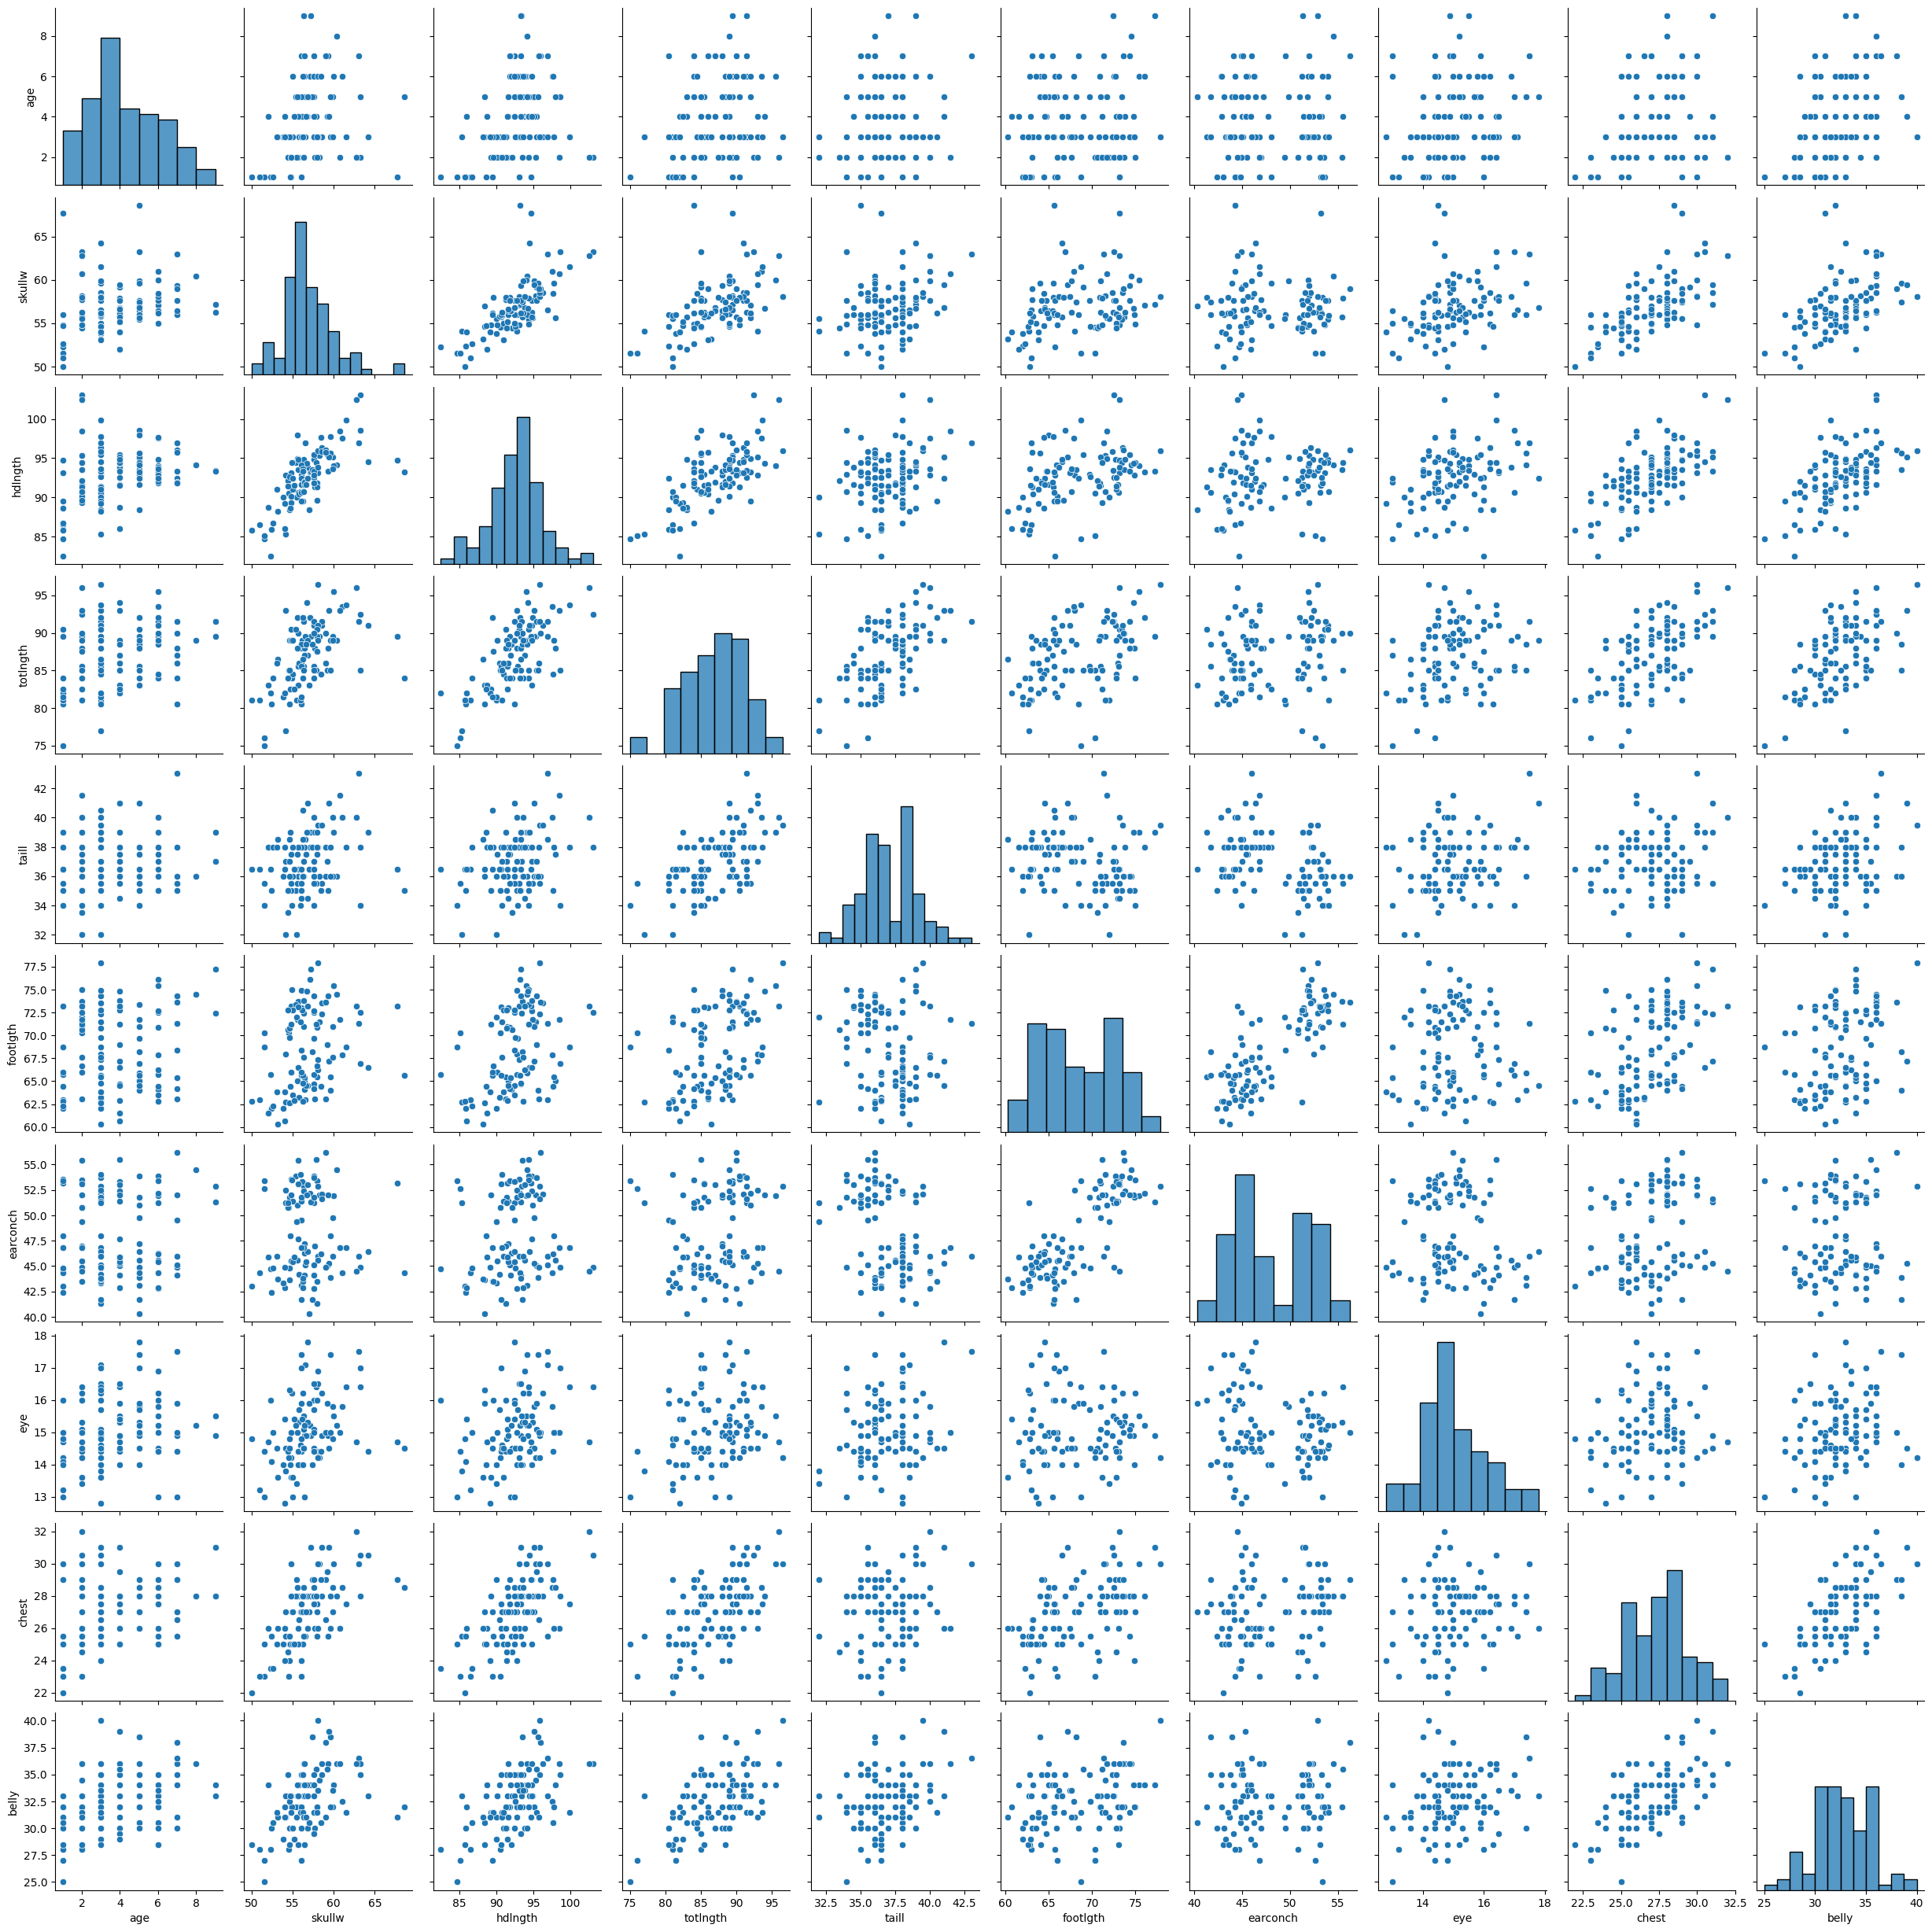

In [170]:
# Pary korelacji
sns.pairplot(df[['age', 'skullw', 'hdlngth', 'totlngth','taill','footlgth','earconch','eye','chest','belly']])
plt.show()

Na tych wykresach widzimy, że age nie ma silnej korelacji z żadną zmienną, dlatego musimy wziąć szereg parametrów pod uwagę podczas przewidywania wieku

In [171]:
# 4. Ponieważ wiek (age) to zmienna docelowa, zdecyduj jak poradzić sobie z brakującymi wartościami w age
subset_columns = ['age', 'footlgth']
existing_columns = [col for col in subset_columns if col in df.columns]
df = df.dropna(subset=existing_columns)

In [172]:
# 5. Określ kolumny kategoryczne i numeryczne
cat_features = ['sex','Pop']
num_features = ['case','site','hdlngth','skullw','totlngth','taill','footlgth','earconch','eye','chest','belly']


In [173]:

# 6. Podziel dane na X i y (y = age), a następnie na zbiór treningowy i testowy
X = df.drop('age', axis=1)
y = df['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
# 7. Stwórz pipeline dla cech numerycznych z imputacją medianą i skalowaniem
num_pipeline = Pipeline([
   ('imputer', SimpleImputer(strategy='median')),
   ('scaler', StandardScaler())
])

In [175]:
# 8. Stwórz pipeline dla cech kategorycznych z OneHotEncoder
cat_pipeline = Pipeline([
   ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [176]:
# 9. Stwórz ColumnTransformer łączący oba pipeline’y
preprocessor = ColumnTransformer([
   ('num', num_pipeline, num_features),
   ('cat', cat_pipeline, cat_features)
], remainder='drop')

In [177]:

# 10. Zbuduj pipeline z modelem regresji liniowej i dopasuj do danych treningowych
lin_pipeline = Pipeline([
   ('preprocessing', preprocessor),
   ('model', LinearRegression())
])
lin_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['case', 'site', 'hdlngth',
                                                   'skullw', 'totlngth',
                                                   'taill', 'footlgth',
                                                   'earconch', 'eye', 'chest',
                                                   'belly']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'Pop'])])),
                ('model', LinearRegression())])

In [178]:


# 11. Dokonaj predykcji na zbiorze testowym i oblicz MSE oraz R² dla modelu liniowego
y_pred_lin = lin_pipeline.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
print("MSE (Linear):", mse_lin)
print("R² (Linear):", r2_lin)


MSE (Linear): 4.332143201972646
R² (Linear): 0.04188808822972079


In [179]:


# 12. Przetestuj Ridge i Lasso dla różnych wartości alpha
alphas = [0.1, 1, 10, 100]
results = []
for alpha in alphas:
    # Ridge
    ridge_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', Ridge(alpha=alpha))
    ])
    ridge_pipeline.fit(X_train, y_train)
    y_pred_ridge = ridge_pipeline.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    # Lasso
    lasso_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', Lasso(alpha=alpha, max_iter=10000))
    ])
    lasso_pipeline.fit(X_train, y_train)
    y_pred_lasso = lasso_pipeline.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)

    results.append({
        'alpha': alpha,
        'MSE_Ridge': mse_ridge,
        'R2_Ridge': r2_ridge,
        'MSE_Lasso': mse_lasso,
        'R2_Lasso': r2_lasso
    })


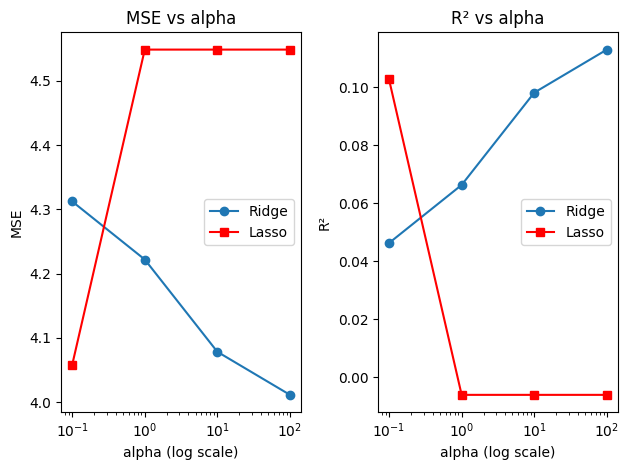

In [180]:
# 13. Wyświetl wyniki w formie tabeli (DataFrame) i narysuj wykres MSE vs alpha oraz R² vs alpha
results_df = pd.DataFrame(results)
(results_df)

plt.subplot(1,2,1)
plt.plot(alphas, results_df['MSE_Ridge'], marker='o', label='Ridge')
plt.plot(alphas, results_df['MSE_Lasso'], marker='s', label='Lasso', color='red')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('MSE')
plt.title('MSE vs alpha')
plt.legend()

plt.subplot(1,2,2)
plt.plot(alphas, results_df['R2_Ridge'], marker='o', label='Ridge')
plt.plot(alphas, results_df['R2_Lasso'], marker='s', label='Lasso', color='red')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('R²')
plt.title('R² vs alpha')
plt.legend()

plt.tight_layout()
plt.show()

# 14. Podsumuj wyniki: Która metoda działa najlepiej? Jak wpływa alpha na model?
Na podstawie wyników można zauważyć, że:
- Model Ridge z wartością alpha = 10 osiągnął najlepszy wynik R² na zbiorze testowym, co wskazuje na jego zdolność do generalizacji. 
Regularyzacja L2 skutecznie ograniczyła wpływ skorelowanych cech na model.

- Model Lasso z wartością alpha = 1 wyeliminował mniej istotne cechy i osiągnął porównywalne wyniki do Ridge. 
Przy wyższych wartościach alpha (np. 100) model zaczął tracić ważne informacje, co doprowadziło do niedouczenia.

- Jednak model Ridge nie dokonuje selekcji cech co w przypadku większej ilości cech ma znaczenie dla szybkości wykonywania operacji i zajmowanej pamięci

- Regresja liniowa bez regularyzacji miała tendencję do przeuczenia przy dużej liczbie cech, szczególnie gdy dane były skorelowane.
Wartość alpha miała istotny wpływ na jakość modeli regularyzowanych. Niskie wartości pozwalały na lepsze dopasowanie do danych treningowych, 
podczas gdy wysokie wartości prowadziły do niedouczenia. Najlepszym modelem okazał się Ridge z umiarkowaną wartością alpha.